# Experiments for extracting images of Boyd's Bird Journal into computer readable form

(See below)

The journals are PDFs containing a series of scanned images of observations of birds. The observations are scanned handwritten notes on graph paper. There are bird species labels running down the left side of the page and date information across the top. The charts are organized by month with days of the month being column headings. There are between 2 and three months of information for each image.

Each cell has a mark indicating the presence or absence of a bird species on a given day. So there is, potentially, one mark per bird species per day. The mark on the page is typically a forward slash "/" but it can also be an "x" or a colored in block. Note that the graphs are not clean and contain other notes and stray marks. Also notice that some of the rules are incomplete or missing.

<img  src="Boyd_M_Bird_journal_section1-024.png"/>

In [1]:
%load_ext watermark
%watermark -a 'Raphael LaFrance' -i -u -v -r -g -p numpy,matplotlib,skimage

Raphael LaFrance 
last updated: 2017-10-05T17:39:26-04:00

CPython 3.6.1
IPython 6.2.0

numpy 1.13.1
matplotlib 2.0.2
skimage 0.13.0
Git hash: d97e91d6a56b14edc1cbf3ca944375766ff44b59
Git repo: https://github.com/rafelafrance/boyd-bird-journal.git


## Extract images from PDF files

First we need to extract individual images from the PDFs. This is easily accomplished in Linux with the command `pdfimages`. This is part of either the poppler or xpdf packages. We're using `bash` to make a directory to hold the images and then extracting the PDF images into that directory.

In [2]:
%%bash

RAW_DATA='raw_data'
DIRECTORY='images'

PDF1="$RAW_DATA/Boyd_M_Bird_journal_section1.pdf"
PDF2="$RAW_DATA/Boyd_M_Bird_journal_section2.pdf"

PREFIX1="$DIRECTORY/Boyd_M_Bird_journal_section1"
PREFIX2="$DIRECTORY/Boyd_M_Bird_journal_section2"

if [ ! -d "$DIRECTORY" ]; then
    mkdir $DIRECTORY
    pdfimages -png $PDF1 $PREFIX1
    pdfimages -png $PDF2 $PREFIX2
fi

## Setup

We are using a fairly standard scipy stack: `numpy` & `matplotlib`. The only addition is the use of `scikit-image`.

In [4]:
%matplotlib notebook

import os

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import cm

# import cv2

from skimage import io
from skimage import util
from skimage.filters import sobel
from skimage.transform import hough_line, hough_line_peaks
from skimage.transform import probabilistic_hough_line, rotate

## Brief description of the Hough transform

We're using the Hough Transform to find lines in the image. It's an efficient and old algorithm for finding objects in an image. Efficient because it only scans the image once.

The basic idea of the algorithm is:

1. Set up a table of every possible line in the image. The lines are in polar form (rho, theta).
    1. Lines are limited to a given set of angles.
    1. This table will hold a count of all of the "on" pixels for the line.
1. Scan the image for "on" pixels.
1. When a pixel is "on", add one to every possible line that goes thru the pixel it.
1. After every pixel has been recorded choose all lines with a count that is greater than a given threshold.

See the [Wikipedia Page](https://en.wikipedia.org/wiki/Hough_transform) for a more detailed description.

## Define some functions

Convert the image into a form the algorithms can use

In [5]:
def preprocess_image(file_name):
    image = io.imread(file_name)
    edges = util.invert(image)  # The algorithm wants white on black
    # image = sobel(image)
    return edges, image

A function for finding lines

In [6]:
def find_grid_lines(img, theta, threshold=500, min_distance=30):

    h_matrix, h_angles, h_dist = hough_line(img, theta)

    values, angles, dists = hough_line_peaks(
        h_matrix,
        h_angles,
        h_dist,
        threshold=threshold,
        min_distance=min_distance)

    return angles, dists

A function to turn the angle (theta) and distance (rho) form into line end points.

In [7]:
def polar2endpoints(angle, dist, img):
    if np.abs(angle) > np.pi / 4:
        x0 = 0
        x1 = img.shape[1]
        y0 = int(np.round(dist / np.sin(angle)))
        y1 = int(np.round((dist - x1 * np.cos(angle)) / np.sin(angle)))
    else:
        y0 = 0
        y1 = img.shape[0]
        x0 = int(np.round(dist / np.cos(angle)))
        x1 = int(np.round((dist - y1 * np.sin(angle)) / np.cos(angle)))
    return [x0, y0], [x1, y1]  # Arrays not tuple so that we can edit them

Find the lines and return the endpoints of the line

In [37]:
def get_lines(edges, thetas, threshold, sort_key):
    
    angles, dists = find_grid_lines(
        edges, thetas, threshold=threshold, min_distance=40)

    lines = [polar2endpoints(t, r, edges)
             for (t, r) in zip(angles, dists)]

    lines = sorted(lines, key=sort_key)

    return lines, angles

In [23]:
edges, image = preprocess_image('images/Boyd_M_Bird_journal_section1-024.png')

## Get the right-hand side of the image

In [24]:
split = image.shape[1] - int(image.shape[1] / 2)

left_side = util.crop(edges, ((0, 0), (0, split)), copy=True)

print(image.shape)
print(left_side.shape)

(5100, 3300)
(5100, 1650)


## Get the horizontal and vertical grid lines

As described above, we need to define a line as a threshold on the line count. However, there is a wrinkle, the images are not square with the width being the shorter dimension (3300px width x 5100px height). To accommodate this we will make two passes over the image. One for the horizontal lines and one for the vertical line.

In [25]:
near_horiz_deg = np.linspace(-2.0, 2.0, num=41)
near_vert_deg = np.linspace(88.0, 92.0, num=41)

print(near_horiz_deg)
print(near_vert_deg)

near_horiz = np.deg2rad(near_horiz_deg)
near_vert = np.deg2rad(near_vert_deg)

[-2.  -1.9 -1.8 -1.7 -1.6 -1.5 -1.4 -1.3 -1.2 -1.1 -1.  -0.9 -0.8 -0.7 -0.6
 -0.5 -0.4 -0.3 -0.2 -0.1  0.   0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9
  1.   1.1  1.2  1.3  1.4  1.5  1.6  1.7  1.8  1.9  2. ]
[ 88.   88.1  88.2  88.3  88.4  88.5  88.6  88.7  88.8  88.9  89.   89.1
  89.2  89.3  89.4  89.5  89.6  89.7  89.8  89.9  90.   90.1  90.2  90.3
  90.4  90.5  90.6  90.7  90.8  90.9  91.   91.1  91.2  91.3  91.4  91.5
  91.6  91.7  91.8  91.9  92. ]


#### This is an oddity of scikit-image?!

In [26]:
near_horiz, near_vert = near_vert, near_horiz

#### Find the horizontal grid lines for the left half of the image

In [75]:
threshold = left_side.shape[1] * 0.4
sort_key = lambda x: x[1][1]

horiz_lines, horiz_angles = get_lines(left_side, near_horiz, threshold, sort_key)
print(len(horiz_lines))
print(np.rad2deg(horiz_angles))

99
[ 90.9  90.9  90.9  90.9  90.9  90.9  90.9  90.9  90.9  90.8  90.9  90.9
  90.7  90.8  90.8  90.9  90.8  90.8  90.8  90.9  90.8  90.9  90.9  90.8
  90.8  90.9  90.8  90.8  90.8  90.9  90.9  90.8  90.9  90.8  90.8  90.8
  90.8  90.8  90.9  90.8  90.9  90.8  90.9  90.9  90.8  90.9  90.8  90.9
  90.9  90.8  90.8  90.8  90.8  90.9  90.8  90.8  90.8  90.9  90.9  90.8
  90.8  90.9  90.9  90.8  90.8  90.8  90.9  90.9  90.8  90.8  90.8  90.9
  90.9  90.8  90.9  90.8  90.8  90.8  90.8  90.8  90.9  90.9  90.9  90.9
  90.7  91.   90.9  90.8  90.9  90.8  90.9  90.8  90.8  90.7  90.6  90.8
  90.8  90.8  90.1]


#### Find the vertical grid lines for the left half of the image

In [74]:
threshold = left_side.shape[0] * 0.4
sort_key = lambda x: x[0][0]

vert_lines, vert_angles = get_lines(left_side, near_vert, threshold, sort_key)

print(len(vert_lines))
print(vert_lines)
print(np.rad2deg(vert_angles))

1
[([493, 0], [466, 5100])]
[ 0.3]


#### Look at the results

<IPython.core.display.Javascript object>


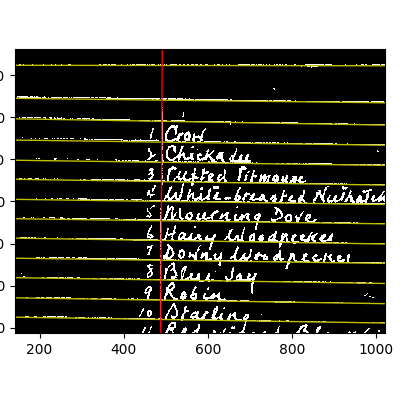

In [29]:
fig, ax = plt.subplots(figsize=(4, 4))
ax.imshow(left_side, cmap=plt.cm.gray)

for ((x0, y0), (x1, y1)) in horiz_lines:
    ax.plot((x0, x1), (y0, y1), '-y', linewidth=1)

for ((x0, y0), (x1, y1)) in vert_lines:
    ax.plot((x0, x1), (y0, y1), '-r', linewidth=1)

plt.tight_layout()
plt.show()

## Look at the second cell in each row

See if there is writing in the cell

<IPython.core.display.Javascript object>


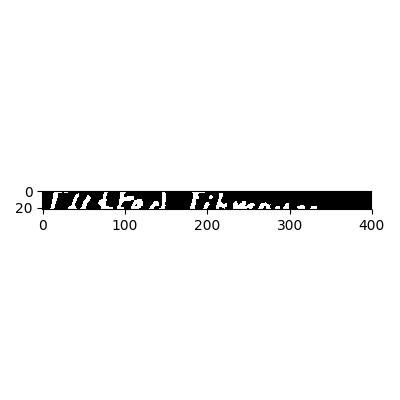

(5100, 1650)
7


In [83]:
fig, ax = plt.subplots(figsize=(4, 4))
# ax.imshow(left_side, cmap=plt.cm.gray)

(v0, w0), (v1, w1) = vert_lines[0]
east = max(v0, v1)

print(left_side.shape)
for i, (((x0, y0), (x1, y1)), ((p0, q0), (p1, q1))) in enumerate(zip(horiz_lines[1:], horiz_lines[:-1])):
    north = max(q0, q1)
    south = left_side.shape[0] - min(y0, y1)
    west = left_side.shape[1] - east - 400
    cell = util.crop(left_side, ((north, south), (east, west)), copy=True)
    if i == 4:
        ax.imshow(cell, cmap=plt.cm.gray)
        lines = probabilistic_hough_line(cell)
        print(len(lines))
        break
# for (p0, p1) in lines:
#     ax.plot((p0[0], p1[0]), (p0[1], p1[1]), '-r', linewidth=1)

#     width = (x1 - x0 - v0) / 2
#     height = q0 - y0
#     # ax.plot((v0, x1), (y0, y1), '-r')
#     ne = (v0, y0)
#     ax.add_patch(
#         patches.Rectangle(
#             ne, width, height, edgecolor='c', fill=False))

plt.tight_layout()
plt.show()

## Look for grid lines.

We want to find the horizontal and vertical grid lines. Because the images are scanned the lines may not be exactly level or straight. So we're looking for lines within a few degrees of horizontal or vertical in small degree increments. Preliminary tests have shown this to be successful for this set of images. Degrees are converted into radians.

We need to swap the image to black on white in the image because the implementation of the Hough transform counts white pixels.

In [7]:
edges, image = preprocess_image('images/Boyd_M_Bird_journal_section1-024.png')

<IPython.core.display.Javascript object>


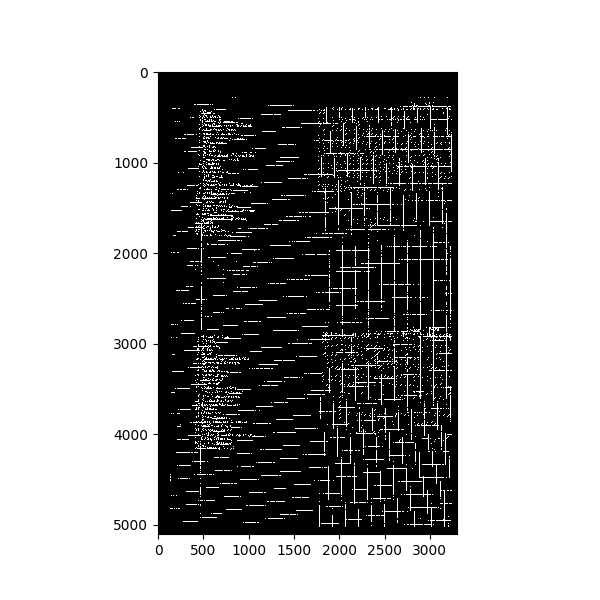

In [8]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(edges, cmap=plt.cm.gray)

### Split the image into sections.

The images are large and the lines are skewed or incomplete. This causes the Hough transform return lines that don't align with the grid throughout the image or miss lines altogether. Breaking the image into sections helps with this.

In [104]:
print(image.shape)

# Chop image vertically to get horizontal lines

split = int(image.shape[1] / 2)

left_beg = 0
left_end = split

right_beg = split
right_end = image.shape[1]

left_side = util.crop(edges, ((0, 0), (0, split)), copy=True)
right_half = util.crop(edges, ((0, 0), (split, 0)), copy=True)


# Chop image horizontally to get vertical lines

split = int(image.shape[0] / 3)

top_beg = 0
top_end = split

middle_beg = split
middle_end = split * 2

bottom_beg = split * 2
bottom_end = split * 3

top_3rd = util.crop(edges, ((0, split * 2), (0, 0)), copy=True)
middle_3rd = util.crop(edges, ((split, split), (0, 0)), copy=True)
bottom_3rd = util.crop(edges, ((split * 2, 0), (0, 0)), copy=True)

(5100, 3300)


Find horizontal grid lines

In [174]:
threshold = edges.shape[1] * 0.15
sort_key = lambda x: x[1][1]

horiz_lines = get_lines(edges, near_horiz, threshold, sort_key)

left_side_lines = get_lines(left_side, near_horiz, threshold, sort_key)
right_half_lines = get_lines(right_half, near_horiz, threshold, sort_key)

print('all', len(horiz_lines))
print('left', len(left_side_lines))
print('right', len(right_half_lines))

all 93
left 99
right 100


Find vertical grid lines

In [175]:
threshold = edges.shape[0] * 0.20
sort_key = lambda x: x[0][0]

vert_lines = get_lines(edges, near_vert, threshold, sort_key)

top_3rd_lines = get_lines(top_3rd, near_vert, threshold, sort_key)
middle_3rd_lines = get_lines(middle_3rd, near_vert, threshold, sort_key)
bottom_3rd_lines = get_lines(bottom_3rd, near_vert, threshold, sort_key)

print('all', len(vert_lines))
print('top', len(top_3rd_lines))
print('middle', len(middle_3rd_lines))
print('bottom', len(bottom_3rd_lines))

all 28
top 32
middle 32
bottom 32


Visually inspect the lines returned by the Hough transform.

<IPython.core.display.Javascript object>


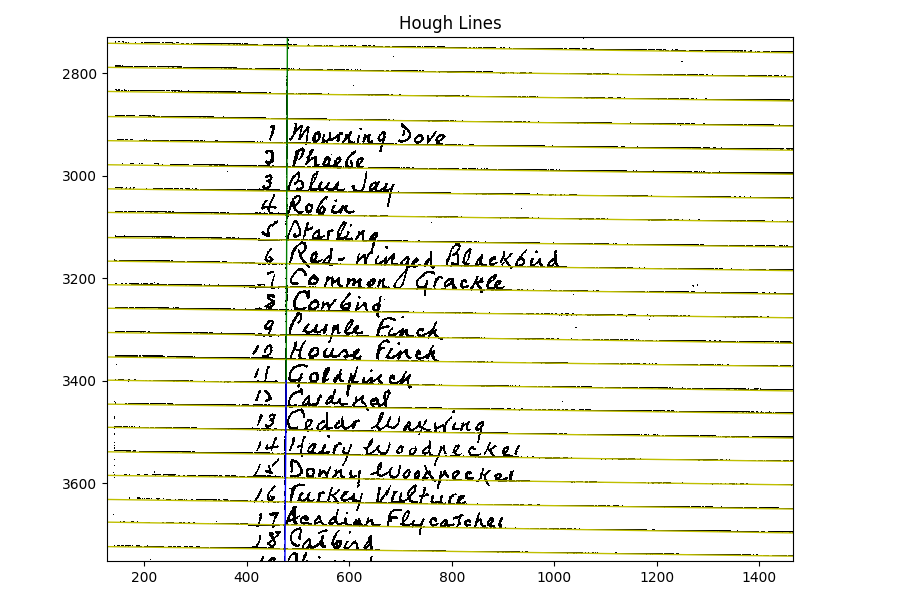

In [111]:
fig, ax = plt.subplots(figsize=(9, 6))

ax.imshow(image, cmap=plt.cm.gray)
ax.set_title('Hough Lines')

for ((x0, y0), (x1, y1)) in left_side_lines:
    ax.plot((x0, x1), (y0, y1), '-y', linewidth=1)

for ((x0, y0), (x1, y1)) in right_half_lines:
    ax.plot((x0 + right_beg, x1 + right_beg), (y0, y1), '-r', linewidth=1)

for ((x0, y0), (x1, y1)) in top_3rd_lines:
    ax.plot((x0, x1), (y0, y1), '-c', linewidth=1)

for ((x0, y0), (x1, y1)) in middle_3rd_lines:
    ax.plot((x0, x1), (y0 + middle_beg, y1 + middle_beg), '-g', linewidth=1)

for ((x0, y0), (x1, y1)) in bottom_3rd_lines:
    ax.plot((x0, x1), (y0 + bottom_beg, y1 + bottom_beg), '-b', linewidth=1)

plt.tight_layout()
plt.show()

## Conclusion from the image splitting experiments

From this we can see that we want to shrink the image as much as possible. We're going to look for cells with writing in them and split the image horizontally when we get a streak of empty row labels. We will reassemble the image for reporting.

## Look for labeled rows

In theory, a data row could have no marks in it (i.e. the bird species did not appear all month) or a non-data row could have extraneous marks in it. We will look for some writing in the row label cells to determine if a row is data row.

So we will be looking at the left side of the vertical split only.

([495, 0], [481, 1700])
([1759, 0], [1750, 1700])
([1816, 0], [1798, 1700])
([1864, 0], [1846, 1700])
([1912, 0], [1894, 1700])
([1960, 0], [1942, 1700])
([2008, 0], [1990, 1700])
([2055, 0], [2037, 1700])
([2103, 0], [2085, 1700])
([2151, 0], [2133, 1700])
([2199, 0], [2181, 1700])
([2247, 0], [2229, 1700])
([2295, 0], [2277, 1700])
([2343, 0], [2325, 1700])
([2391, 0], [2373, 1700])
([2438, 0], [2420, 1700])
([2486, 0], [2468, 1700])
([2534, 0], [2516, 1700])
([2582, 0], [2564, 1700])
([2630, 0], [2612, 1700])
([2678, 0], [2660, 1700])
([2726, 0], [2708, 1700])
([2774, 0], [2756, 1700])
([2822, 0], [2804, 1700])
([2869, 0], [2851, 1700])
([2917, 0], [2899, 1700])
([2965, 0], [2947, 1700])
([3012, 0], [2994, 1700])
([3060, 0], [3042, 1700])
([3108, 0], [3090, 1700])
([3155, 0], [3137, 1700])
([3202, 0], [3184, 1700])


## Look for presence or absence marks in the data cells

## Failed experiments

## Try merging endpoints

If it works then it will simplify things a lot.

<IPython.core.display.Javascript object>


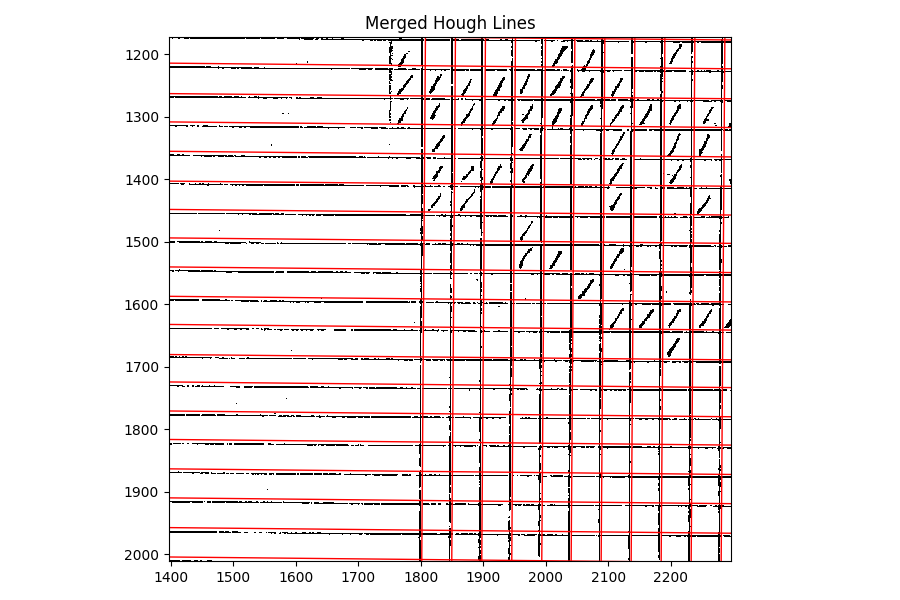

In [88]:
horiz_points = [[l0, [x + right_beg, y]]
                for (l0, l1), (r0, (x, y)) in zip(left_side_lines, right_half_lines)]

fig, ax = plt.subplots(figsize=(9, 6))

ax.imshow(image, cmap=plt.cm.gray)
ax.set_title('Merged Hough Lines')

for ((x0, y0), (x1, y1)) in horiz_points:
    ax.plot((x0, x1), (y0, y1), '-r', linewidth=1)

vert_points = []
for (t0, t1), (b0, (x, y)) in zip(top_3rd_lines[2:], bottom_3rd_lines[1:]):
    vert_points.append([t0, [x, y + bottom_beg]])

for ((x0, y0), (x1, y1)) in vert_points:
    ax.plot((x0, x1), (y0, y1), '-r', linewidth=1)

plt.tight_layout()
plt.show()

### Probabilistic Hough line

It proved to be much slower and harder to tune for finding grid lines that span the entire image.

In [18]:
threshold = edges.shape[1] * 0.2

lines = probabilistic_hough_line(edges, threshold=threshold, line_length=50, line_gap=100, theta=near_horiz)
print(len(lines))

1940


<IPython.core.display.Javascript object>


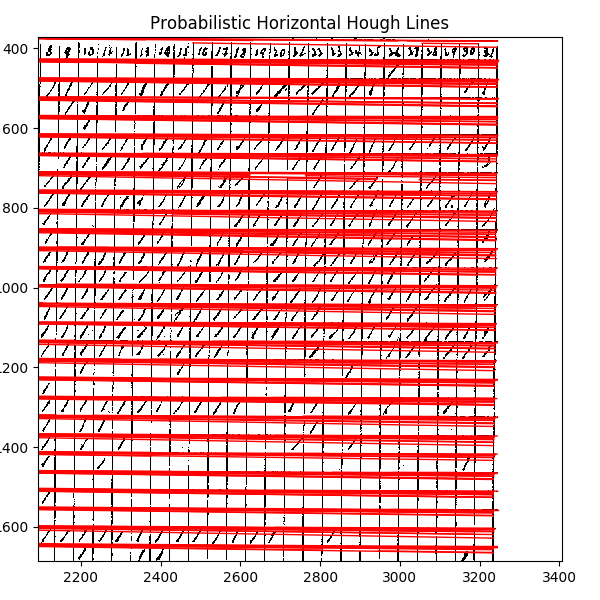

In [19]:
fig, ax = plt.subplots(figsize=(6, 6))

ax.imshow(image, cmap=plt.cm.gray)
ax.set_title('Probabilistic Horizontal Hough Lines')

for (p0, p1) in lines:
    ax.plot((p0[0], p1[0]), (p0[1], p1[1]), '-r', linewidth=1)

plt.tight_layout()
plt.show()

### OpenCV

This works, it's just less flexible for searching on a limited set of angles. The ability to pull out the horizontal, vertical, and diagonal lines separately is useful in this application.

This function reads in an image and performs needed preprocessing to get the image into a form the algorithms can use efficiently.

In [68]:
def preprocess_image_cv2(file_name):
    image = cv2.imread(file_name)
    edges = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # edges = cv2.Canny(edges, 50, 150, apertureSize=3)
    return edges, image

In [67]:
edges, image = preprocess_image_cv2('images/Boyd_M_Bird_journal_section1-024.png')
print(image.shape)

(5100, 3300, 3)


<IPython.core.display.Javascript object>


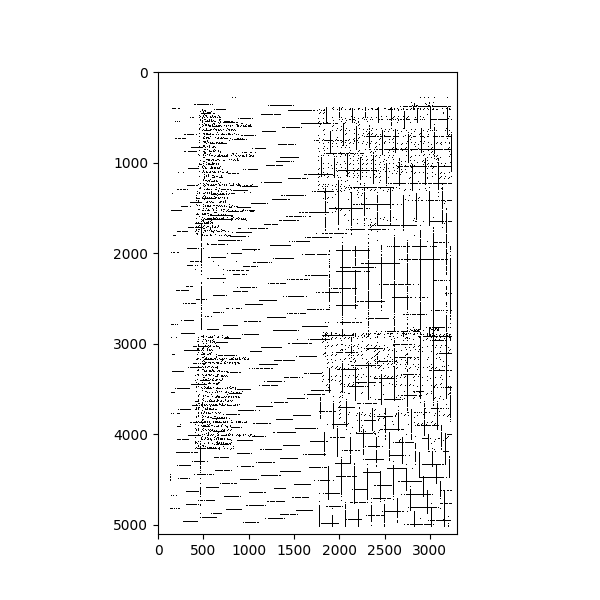

In [70]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(image, cmap=plt.cm.gray)

In [71]:
threshold = int(image.shape[1] * 0.2)
rho_resolution = 1                # in pixels
theta_resolution = np.pi / 360.0  # in radians

lines = cv2.HoughLines(edges, rho_resolution, theta_resolution, threshold)
print(len(lines))

304


In [72]:
img = np.copy(image)
for line in lines:
    rho, theta = line[0]
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a * rho
    y0 = b * rho
    x1 = int(x0 + img.shape[0] * -b)
    y1 = int(y0 + img.shape[0] * a)
    x2 = int(x0 - img.shape[1] * -b)
    y2 = int(y0 - img.shape[1] * a)

    cv2.line(img, (x1, y1), (x2, y2), (0, 0, 255), 2)

<IPython.core.display.Javascript object>


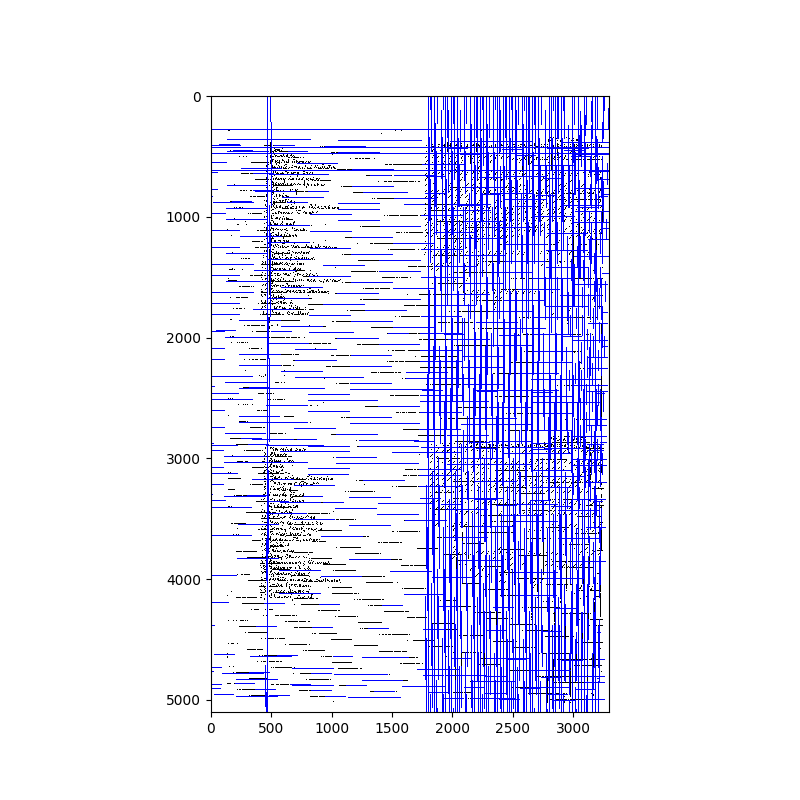

In [73]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(img, cmap=plt.cm.gray)

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].imshow(edges, cmap=plt.cm.gray)
ax[0].set_title('Input image')

ax[1].imshow(image, cmap=plt.cm.gray)
ax[1].set_title('Raw Image')

plt.tight_layout()
plt.show()